# Long Short-Term Memory

## Initialization

### Import Libraries

In [ ]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras Layers
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

from sklearn.metrics import f1_score

### Import Data

In [2]:
df_train = pd.read_csv('../dataset/train.csv', sep=',')
df_val = pd.read_csv('../dataset/valid.csv', sep=',')
df_test = pd.read_csv('../dataset/test.csv', sep=',')

In [3]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

for df in [df_train, df_val, df_test]:
    df['label_id'] = df['label'].map(label_mapping)

    if df['label_id'].isnull().any():
        print("Warning: Some labels were not mapped! Check unique labels and label_mapping.")
        print(df[df['label_id'].isnull()])

x_train = np.array(df_train['text'])
y_train = np.array(df_train['label_id'])

x_val = np.array(df_val['text'])
y_val = np.array(df_val['label_id'])

x_test = np.array(df_test['text'])
y_test = np.array(df_test['label_id'])

In [4]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (500,), y_train shape: (500,)
x_val shape: (100,), y_val shape: (100,)
x_test shape: (400,), y_test shape: (400,)


## Preprocessing

Tokenized lengths: [16, 22, 6, 57, 5, 8, 6, 23, 8, 32, 77, 16, 43, 25, 47, 31, 19, 17, 9, 43, 23, 12, 37, 17, 12, 42, 12, 11, 37, 43, 7, 10, 24, 22, 13, 20, 15, 43, 28, 17, 43, 52, 36, 17, 8, 19, 28, 22, 22, 24, 7, 5, 15, 29, 15, 56, 27, 42, 11, 18, 36, 15, 19, 58, 7, 16, 7, 6, 8, 13, 15, 26, 20, 35, 6, 15, 27, 18, 47, 34, 24, 15, 41, 13, 10, 36, 15, 8, 20, 29, 23, 27, 35, 19, 33, 18, 40, 7, 33, 22, 17, 7, 18, 43, 20, 7, 49, 11, 63, 10, 11, 32, 18, 13, 46, 27, 29, 21, 42, 32, 21, 24, 49, 10, 56, 32, 30, 14, 16, 17, 19, 13, 40, 10, 9, 31, 14, 66, 23, 8, 33, 12, 26, 54, 18, 40, 30, 24, 7, 38, 57, 23, 24, 10, 19, 10, 21, 23, 18, 13, 17, 8, 58, 11, 27, 16, 13, 10, 43, 13, 30, 34, 23, 33, 6, 7, 22, 49, 7, 9, 6, 19, 41, 16, 38, 18, 14, 20, 17, 19, 28, 9, 31, 16, 27, 11, 54, 20, 50, 9, 9, 49, 9, 12, 20, 18, 46, 39, 15, 24, 24, 45, 13, 55, 11, 7, 7, 55, 41, 48, 30, 48, 24, 22, 59, 31, 23, 29, 54, 61, 29, 24, 56, 60, 6, 40, 41, 28, 8, 57, 16, 10, 19, 22, 22, 20, 28, 9, 55, 9, 19, 9, 50, 16, 9, 

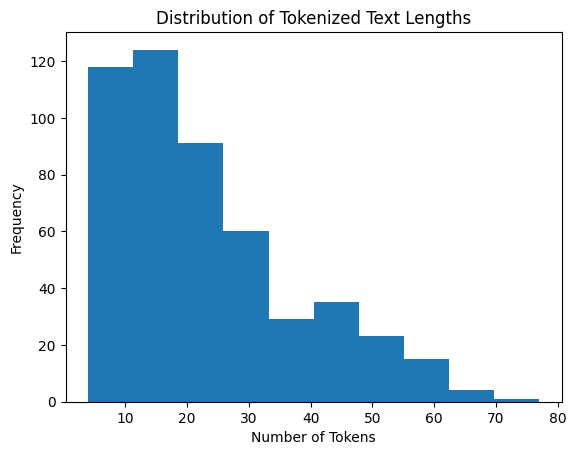

In [5]:
temp_vectorizer = layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
temp_vectorizer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

tokenized_lengths = []
for text in x_train:
    tokens = temp_vectorizer([text]).numpy()[0]
    tokenized_lengths.append(np.count_nonzero(tokens))

print("Tokenized lengths:", tokenized_lengths)
print("Mean length:", np.mean(tokenized_lengths))
print("Median length:", np.median(tokenized_lengths))
print("Max length:", np.max(tokenized_lengths))
print("90th percentile:", np.percentile(tokenized_lengths, 90))
print("95th percentile:", np.percentile(tokenized_lengths, 95))

plt.hist(tokenized_lengths, bins=10)
plt.title('Distribution of Tokenized Text Lengths')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.show()

In [6]:
vectorize_layer_full_vocab = layers.TextVectorization(
    max_tokens=None,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)

vectorize_layer_full_vocab.adapt(tf.data.Dataset.from_tensor_slices(x_train))

full_vocabulary = vectorize_layer_full_vocab.get_vocabulary()

print(f"Total unique tokens (including OOV if present): {len(full_vocabulary)}")
print("Top 20 most frequent tokens:", full_vocabulary[:20])
print("Some of the least frequent tokens:", full_vocabulary[-20:])

Total unique tokens (including OOV if present): 2836
Top 20 most frequent tokens: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]
Some of the least frequent tokens: [np.str_('360'), np.str_('2x'), np.str_('2baso'), np.str_('2910'), np.str_('270'), np.str_('25000'), np.str_('250'), np.str_('2012'), np.str_('2002'), np.str_('1996'), np.str_('190000'), np.str_('18'), np.str_('1748'), np.str_('16'), np.str_('15000'), np.str_('150'), np.str_('14000'), np.str_('120'), np.str_('12'), np.str_('1000')]


### Preprocessing Result
Since the number of unique tokens is not significantly large, we will use (2836+1) **2837 as the vocabulary size** (max_tokens) and take the 95th percentile value of **54 as the output_sequence_length**

In [7]:
MAX_TOKENS = 2837
OUTPUT_SEQUENCE_LENGTH = 54
EMBEDDING_DIM = 64
NUM_CLASSES = 3

MODEL_SAVE_DIR = '../bin/lstm_models'
PLOT_SAVE_DIR = '../bin/lstm_plots'

In [8]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [9]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH
)

text_vectorization_layer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

## Training and Prediction

### Boilerplate Functions

In [10]:
def calculate_macro_f1(y_true, y_pred_classes):
    return f1_score(y_true, y_pred_classes, average='macro')

def plot_training_history(history, title, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, filename))
    plt.show()
    plt.close()

In [11]:
def build_lstm_model(num_lstm_layers=1, lstm_units=64, lstm_direction='unidirectional', num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization_layer)
    model.add(layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True,
    ))

    for i in range(num_lstm_layers):
        return_sequences = (i < num_lstm_layers - 1)

        if lstm_direction == 'unidirectional':
            model.add(layers.LSTM(lstm_units, return_sequences=return_sequences))
        elif lstm_direction == 'bidirectional':
            model.add(layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=return_sequences)))
        else:
            raise ValueError("lstm_direction must be 'unidirectional' or 'bidirectional'")

        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_and_evaluate_model(model_name, model_params, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    print(f"\n--- Training Model: {model_name} ---")
    model = build_lstm_model(**model_params)
    model.summary()

    # Define callbacks
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure directory exists
    best_model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best_val_loss.h5')

    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=best_model_filepath,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )
    early_stopping_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=0
    )

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    print(f"Best Keras model (based on val_loss) was saved to: {best_model_filepath}")

    plot_title = f"{model_name}"
    plot_filename_path = f"{model_name}_loss_accuracy.png"
    plot_training_history(history, plot_title, plot_filename_path)

    y_val_pred_probs = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

    y_test_pred_probs = model.predict(x_test)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

    return history, y_val_pred_classes, y_test_pred_classes

In [13]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    """
    Calculates and prints the macro F1-score.
    """
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

### Variation in Number of LSTM Layers


--- Training Model: LSTM_Layers_1 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,787 (839.01 KB)

 Trainable params: 214,787 (839.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3952 - loss: 1.0894

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3966 - loss: 1.0888 - val_accuracy: 0.6000 - val_loss: 1.0436
Epoch 2/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5026 - loss: 0.9891

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5034 - loss: 0.9851 - val_accuracy: 0.5800 - val_loss: 0.9567
Epoch 3/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7229 - loss: 0.7970

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7325 - loss: 0.7922 - val_accuracy: 0.6900 - val_loss: 0.8502
Epoch 4/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8741 - loss: 0.5457

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.8774 - loss: 0.5362 - val_accuracy: 0.7000 - val_loss: 0.8193
Epoch 5/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9427 - loss: 0.3039

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9422 - loss: 0.3014 - val_accuracy: 0.7400 - val_loss: 0.7866
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9765 - loss: 0.1575 - val_accuracy: 0.7200 - val_loss: 0.8461
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9935 - loss: 0.1046 - val_accuracy: 0.7300 - val_loss: 0.8664
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9942 - loss: 0.0527 - val_accuracy: 0.7200 - val_loss: 0.9064
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9979 - loss: 0.0319 - val_accuracy: 0.6800 - val_loss: 1.0075
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9987 - loss: 0.0268 - val_accuracy: 0.7200 - val_loss: 1.0667
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_1_best_val_loss.h5


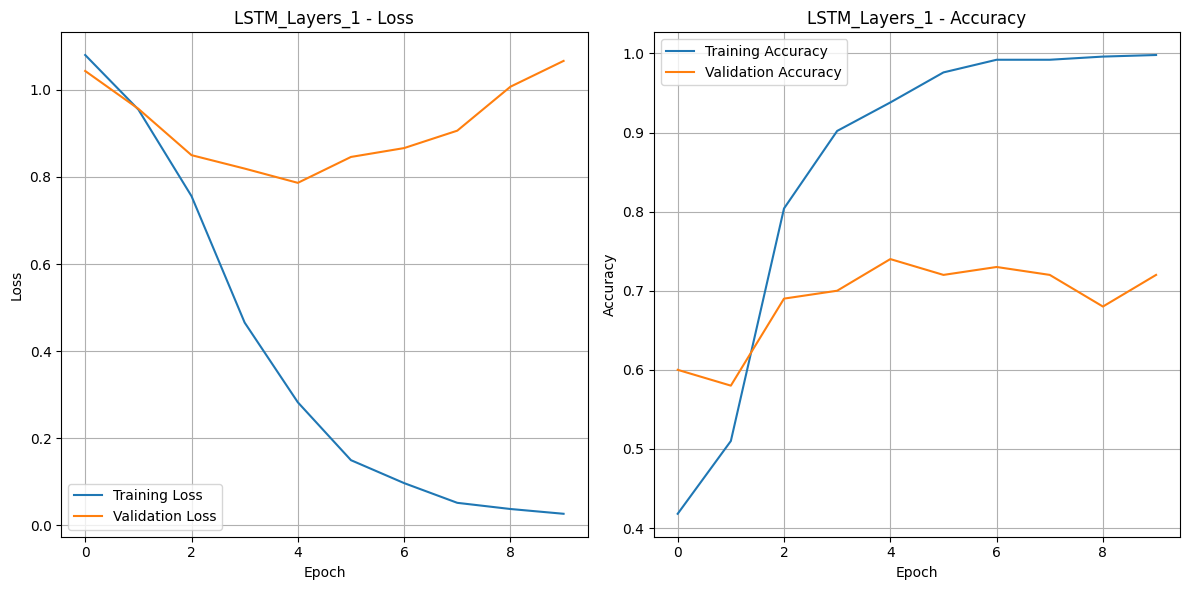

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Macro F1-score on Validation set: 0.7334
Macro F1-score on Test set: 0.7416

--- Training Model: LSTM_Layers_2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4178 - loss: 1.0892

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 0.4190 - loss: 1.0885 - val_accuracy: 0.4000 - val_loss: 1.0311
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4090 - loss: 0.9833

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.4141 - loss: 0.9810 - val_accuracy: 0.6300 - val_loss: 0.9229
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.7144 - loss: 0.7582

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7128 - loss: 0.7564 - val_accuracy: 0.6200 - val_loss: 0.8609
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.8199 - loss: 0.5028 - val_accuracy: 0.6300 - val_loss: 0.8813
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9571 - loss: 0.2330

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9575 - loss: 0.2313 - val_accuracy: 0.7600 - val_loss: 0.8432
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9767 - loss: 0.1337 - val_accuracy: 0.7300 - val_loss: 0.8976
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9938 - loss: 0.0496 - val_accuracy: 0.7500 - val_loss: 0.9943
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9987 - loss: 0.0317 - val_accuracy: 0.7400 - val_loss: 1.0045
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9931 - loss: 0.0380 - val_accuracy: 0.7300 - val_loss: 0.9927
Epoch 10/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9977 - loss: 0.0164 - val_accuracy: 0.7900 - val_loss: 1.0545
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_2_best_val_loss.h5


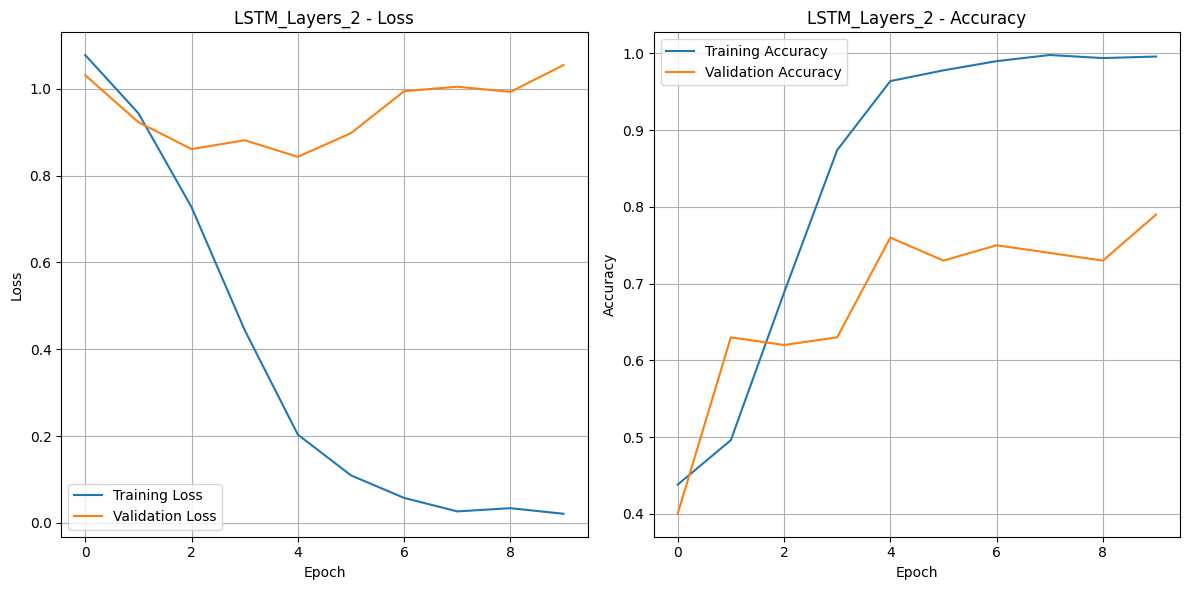

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Macro F1-score on Validation set: 0.7564
Macro F1-score on Test set: 0.7310

--- Training Model: LSTM_Layers_3 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,835 (1.07 MB)

 Trainable params: 280,835 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.3722 - loss: 1.0780

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.3722 - loss: 1.0766 - val_accuracy: 0.3900 - val_loss: 1.0358
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5000 - loss: 0.9134

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.5027 - loss: 0.9131 - val_accuracy: 0.5500 - val_loss: 0.9487
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.6975 - loss: 0.7333

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.6975 - loss: 0.7303 - val_accuracy: 0.6100 - val_loss: 0.8852
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.7500 - loss: 0.5033 - val_accuracy: 0.6400 - val_loss: 0.9382
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.8879 - loss: 0.3199 - val_accuracy: 0.6600 - val_loss: 0.9638
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9644 - loss: 0.1402 - val_accuracy: 0.6800 - val_loss: 1.1356
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.9894 - loss: 0.0474 - val_accuracy: 0.7300 - val_loss: 1.1890
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.9996 - loss: 0.0238 - val_accuracy: 0.7100 - val_loss: 1.3370
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Layers_3_best_val_loss.h5


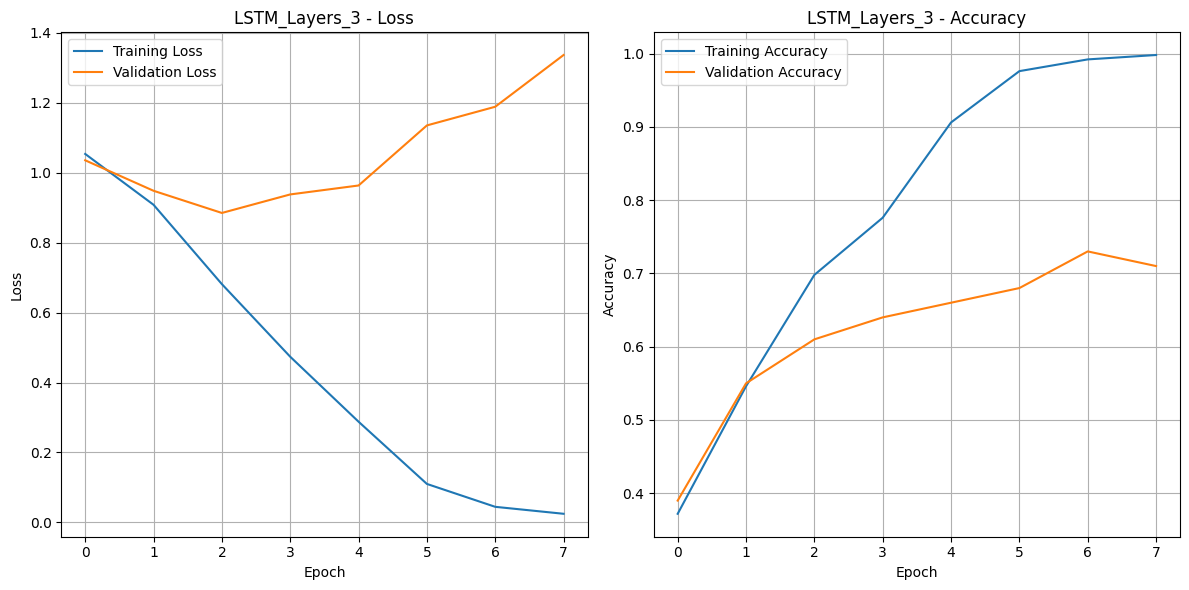

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 333ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Macro F1-score on Validation set: 0.4677
Macro F1-score on Test set: 0.4683

--- Summary: Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Validation Macro F1 = 0.7334, Test Macro F1 = 0.7416
LSTM_Layers_2: Validation Macro F1 = 0.7564, Test Macro F1 = 0.7310
LSTM_Layers_3: Validation Macro F1 = 0.4677, Test Macro F1 = 0.4683


In [14]:
lstm_layer_variations = [1, 2, 3]

results_layer_count = {}

for num_layers in lstm_layer_variations:
    model_params = {
        'num_lstm_layers': num_layers,
        'lstm_units': 64,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Layers_{num_layers}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_layer_count[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jumlah layer LSTM ---")
for name, res in results_layer_count.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")


### Variation in Number of LSTM Cells


--- Training Model: LSTM_Units_32 ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 54, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,403 (790.64 KB)

 Trainable params: 202,403 (790.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3735 - loss: 1.0918

16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 154ms/step - accuracy: 0.3750 - loss: 1.0914 - val_accuracy: 0.4100 - val_loss: 1.0550
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.4338 - loss: 1.0062

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.4352 - loss: 1.0041 - val_accuracy: 0.5200 - val_loss: 0.9523
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6933 - loss: 0.8068

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.6938 - loss: 0.8030 - val_accuracy: 0.6400 - val_loss: 0.8280
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7600 - loss: 0.4954

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7587 - loss: 0.4965 - val_accuracy: 0.6900 - val_loss: 0.7834
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9255 - loss: 0.3416 - val_accuracy: 0.6900 - val_loss: 0.8352
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9766 - loss: 0.1812 - val_accuracy: 0.7500 - val_loss: 0.8504
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9892 - loss: 0.1112 - val_accuracy: 0.7500 - val_loss: 0.9730
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9975 - loss: 0.0430 - val_accuracy: 0.7400 - val_loss: 1.0997
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9942 - loss: 0.0426 - val_accuracy: 0.7200 - val_loss: 1.1821
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_32_best_val_loss.h5


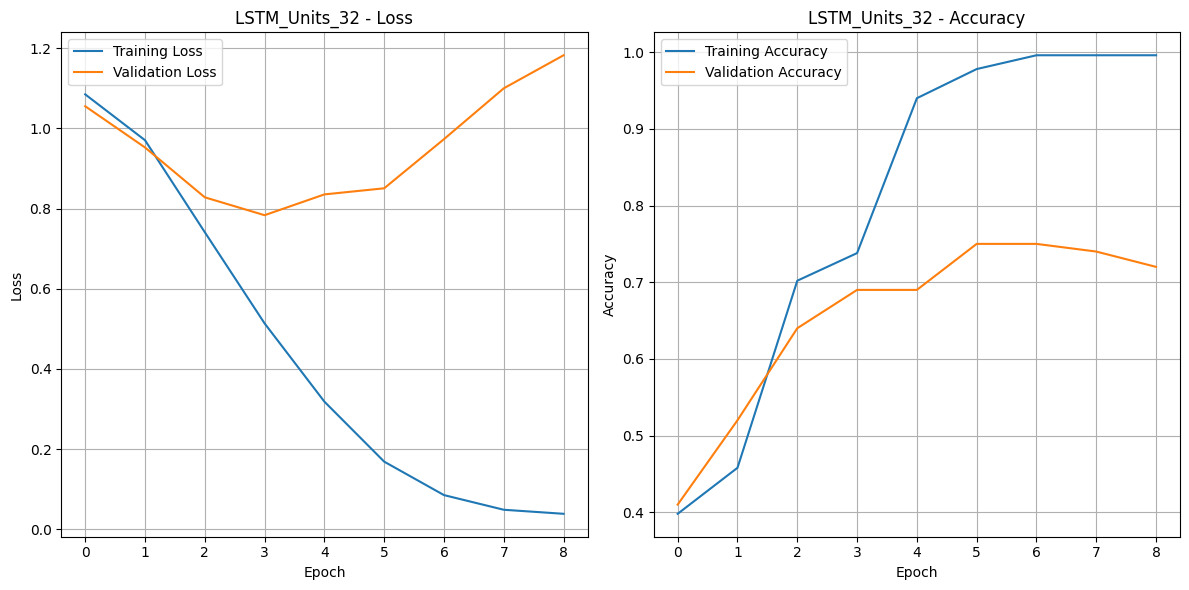

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Macro F1-score on Validation set: 0.5862
Macro F1-score on Test set: 0.5031

--- Training Model: LSTM_Units_64 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4728 - loss: 1.0826

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.4725 - loss: 1.0796 - val_accuracy: 0.4100 - val_loss: 1.0434
Epoch 2/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4931 - loss: 0.9444

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5005 - loss: 0.9414 - val_accuracy: 0.6400 - val_loss: 0.8968
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7973 - loss: 0.6842

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.7963 - loss: 0.6814 - val_accuracy: 0.6400 - val_loss: 0.8959
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8752 - loss: 0.3898

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.8776 - loss: 0.3874 - val_accuracy: 0.7700 - val_loss: 0.7884
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9665 - loss: 0.1710 - val_accuracy: 0.7600 - val_loss: 0.9300
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9784 - loss: 0.1236 - val_accuracy: 0.7500 - val_loss: 1.0362
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9943 - loss: 0.0436 - val_accuracy: 0.7700 - val_loss: 1.0920
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.9990 - loss: 0.0210 - val_accuracy: 0.7500 - val_loss: 1.2227
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9970 - loss: 0.0170 - val_accuracy: 0.7600 - val_loss: 1.1407
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_64_best_val_loss.h5


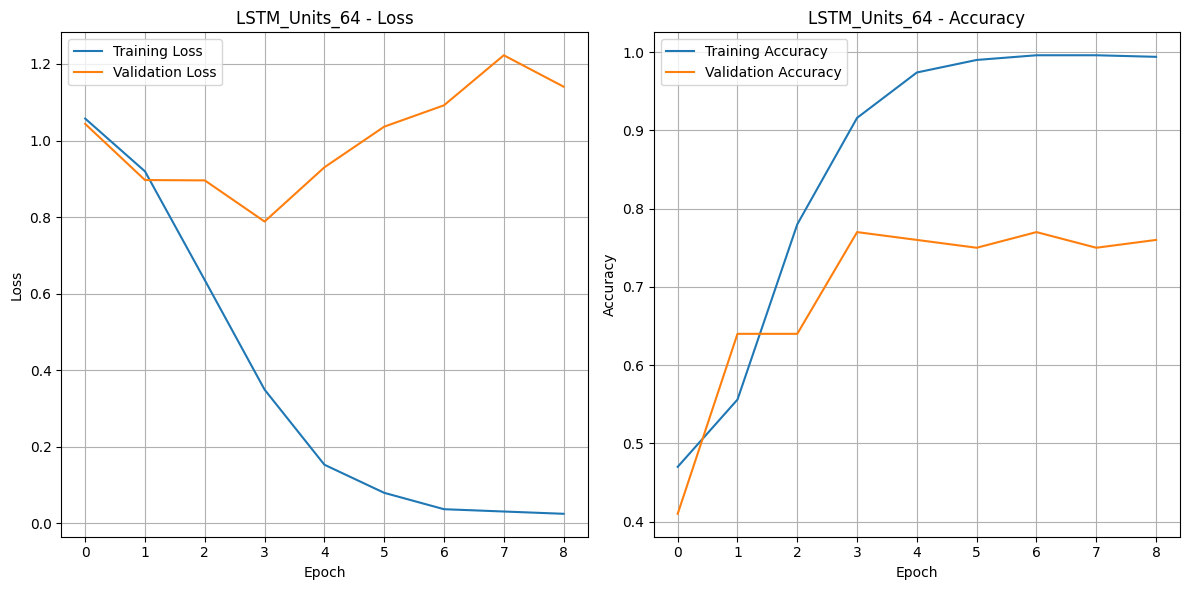

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 354ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Macro F1-score on Validation set: 0.7685
Macro F1-score on Test set: 0.7464

--- Training Model: LSTM_Units_128 ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 54, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,355 (1.57 MB)

 Trainable params: 412,355 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.3559 - loss: 1.0768

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 0.3585 - loss: 1.0750 - val_accuracy: 0.6200 - val_loss: 1.0122
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5908 - loss: 0.9271

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.5937 - loss: 0.9219 - val_accuracy: 0.6100 - val_loss: 0.8598
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.7335 - loss: 0.5598

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 0.7352 - loss: 0.5574 - val_accuracy: 0.7300 - val_loss: 0.7287
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9578 - loss: 0.3071 - val_accuracy: 0.6800 - val_loss: 1.1661
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9499 - loss: 0.1888 - val_accuracy: 0.7300 - val_loss: 0.9104
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9939 - loss: 0.0561 - val_accuracy: 0.7100 - val_loss: 1.0677
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.9941 - loss: 0.0408 - val_accuracy: 0.7000 - val_loss: 0.9264
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9982 - loss: 0.0210 - val_accuracy: 0.7200 - val_loss: 1.1014
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Units_128_best_val_loss.h5


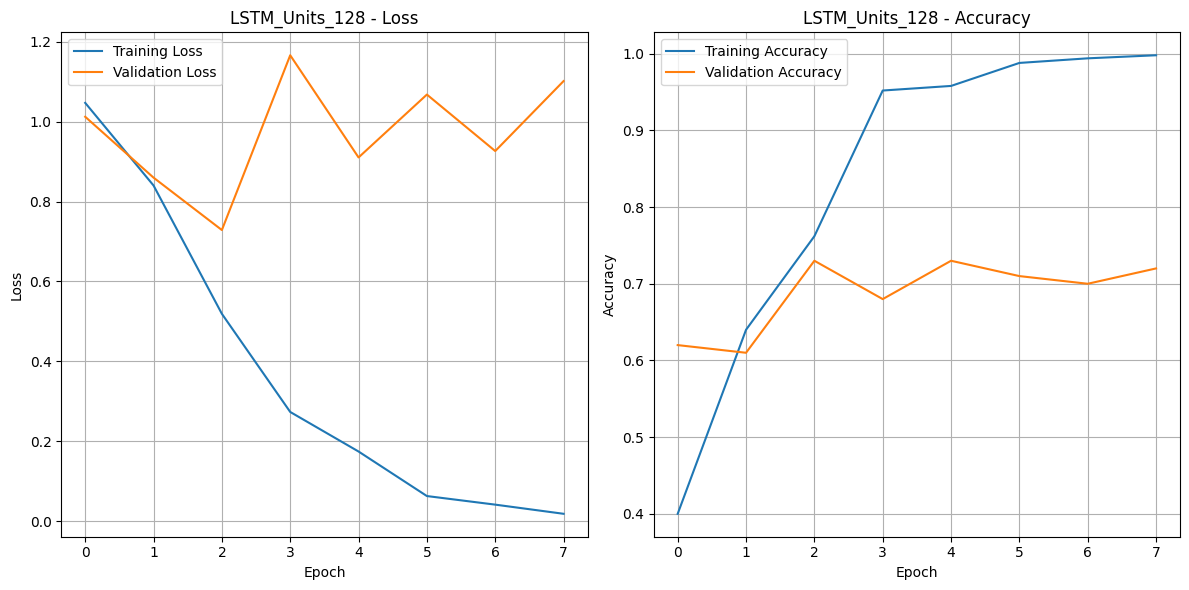

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Macro F1-score on Validation set: 0.7134
Macro F1-score on Test set: 0.7350

--- Summary: Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Validation Macro F1 = 0.5862, Test Macro F1 = 0.5031
LSTM_Units_64: Validation Macro F1 = 0.7685, Test Macro F1 = 0.7464
LSTM_Units_128: Validation Macro F1 = 0.7134, Test Macro F1 = 0.7350


In [15]:
lstm_units_variations = [32, 64, 128]

results_units = {}

for units in lstm_units_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': units,
        'lstm_direction': 'unidirectional'
    }
    model_name = f"LSTM_Units_{units}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_units[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh banyak cell LSTM per layer ---")
for name, res in results_units.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Variation in LSTM Layer Direction


--- Training Model: LSTM_Direction_unidirectional ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,811 (968.01 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3764 - loss: 1.0895

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.3786 - loss: 1.0883 - val_accuracy: 0.4400 - val_loss: 1.0322
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4557 - loss: 0.9626

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4592 - loss: 0.9614 - val_accuracy: 0.5900 - val_loss: 0.9224
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7528 - loss: 0.7493

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7543 - loss: 0.7451 - val_accuracy: 0.5600 - val_loss: 0.9115
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8338 - loss: 0.3857

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.8367 - loss: 0.3834 - val_accuracy: 0.7000 - val_loss: 0.8494
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9633 - loss: 0.1783 - val_accuracy: 0.6800 - val_loss: 1.0340
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9891 - loss: 0.0764 - val_accuracy: 0.7400 - val_loss: 0.9935
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9995 - loss: 0.0251 - val_accuracy: 0.7500 - val_loss: 1.1195
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9987 - loss: 0.0172 - val_accuracy: 0.7400 - val_loss: 1.2112
Epoch 9/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.9964 - loss: 0.0153 - val_accuracy: 0.7400 - val_loss: 1.3073
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Direction_unidirectional_best_val_loss.h5


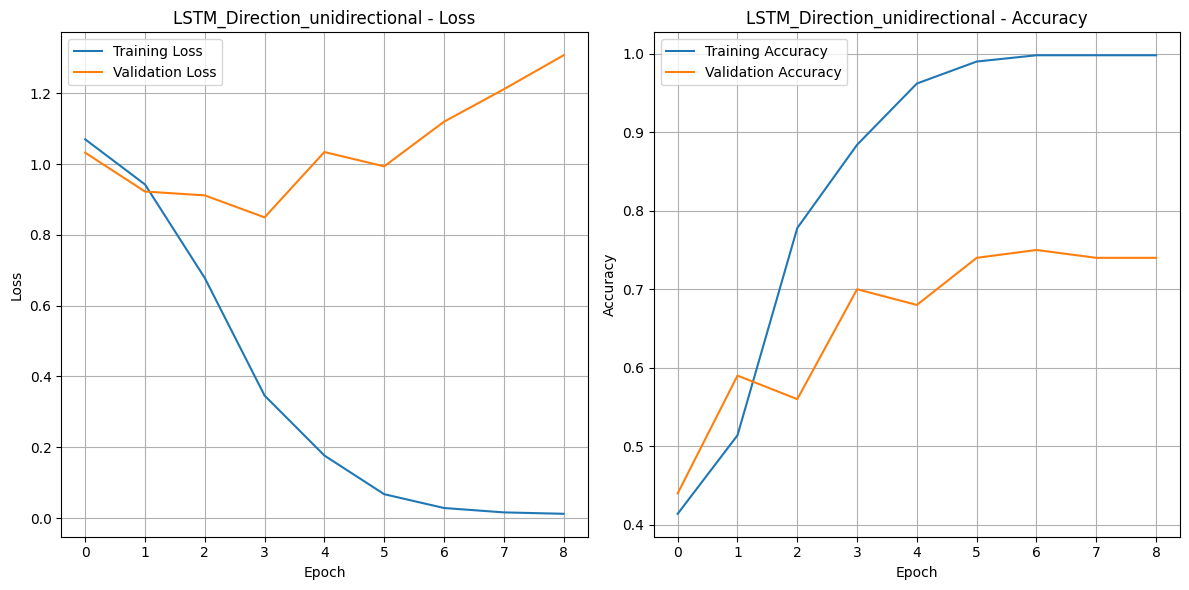

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 535ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Macro F1-score on Validation set: 0.6967
Macro F1-score on Test set: 0.7159

--- Training Model: LSTM_Direction_bidirectional ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,819 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3799 - loss: 1.0860

16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.3816 - loss: 1.0848 - val_accuracy: 0.4000 - val_loss: 1.0148
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4910 - loss: 0.9268

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.4979 - loss: 0.9216 - val_accuracy: 0.5900 - val_loss: 0.8285
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7278 - loss: 0.5362

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7311 - loss: 0.5324 - val_accuracy: 0.7600 - val_loss: 0.8040
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9679 - loss: 0.2399 - val_accuracy: 0.7300 - val_loss: 0.8664
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9865 - loss: 0.0724 - val_accuracy: 0.7500 - val_loss: 1.0244
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9971 - loss: 0.0292 - val_accuracy: 0.7200 - val_loss: 1.3877
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.9870 - loss: 0.0369 - val_accuracy: 0.7300 - val_loss: 1.2342
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.9915 - loss: 0.0547 - val_accuracy: 0.7500 - val_loss: 1.2572
Best Keras model (based on val_loss) was saved to: ../bin/lstm_models\LSTM_Direction_bidirectional_best_val_loss.h5


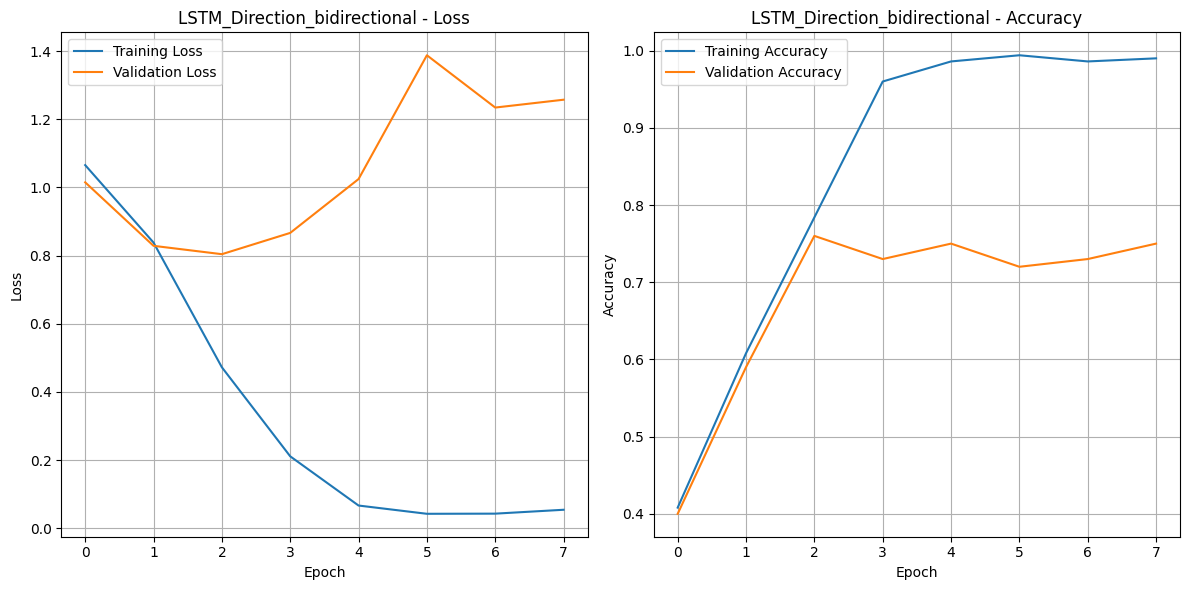

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Macro F1-score on Validation set: 0.7509
Macro F1-score on Test set: 0.7429

--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Validation Macro F1 = 0.6967, Test Macro F1 = 0.7159
LSTM_Direction_bidirectional: Validation Macro F1 = 0.7509, Test Macro F1 = 0.7429


In [17]:
lstm_direction_variations = ['unidirectional', 'bidirectional']

results_direction = {}

for direction in lstm_direction_variations:
    model_params = {
        'num_lstm_layers': 2,
        'lstm_units': 64,
        'lstm_direction': direction
    }
    model_name = f"LSTM_Direction_{direction}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_direction[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jenis layer LSTM berdasarkan arah ---")
for name, res in results_direction.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Overall Analysis and Conclusions

In [ ]:
def print_conclusion(experiment_name, results_dict):
    print(f"\n--- {experiment_name} ---")
    best_val_f1 = -1
    best_model_name = ""
    for name, res in results_dict.items():
        print(f"{name}: Val Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")
        if res['val_macro_f1'] > best_val_f1:
            best_val_f1 = res['val_macro_f1']
            best_model_name = name
    print(f"Best performing model in this experiment (based on Validation F1): {best_model_name} (F1: {best_val_f1:.4f})")

print_conclusion("Pengaruh jumlah layer LSTM", results_layer_count)
print_conclusion("Pengaruh banyak cell LSTM per layer", results_units)
print_conclusion("Pengaruh jenis layer LSTM berdasarkan arah", results_direction)


--- Pengaruh jumlah layer LSTM ---
LSTM_Layers_1: Val Macro F1 = 0.7334, Test Macro F1 = 0.7416
LSTM_Layers_2: Val Macro F1 = 0.7564, Test Macro F1 = 0.7310
LSTM_Layers_3: Val Macro F1 = 0.4677, Test Macro F1 = 0.4683
Best performing model in this experiment (based on Validation F1): LSTM_Layers_2 (F1: 0.7564)

--- Pengaruh banyak cell LSTM per layer ---
LSTM_Units_32: Val Macro F1 = 0.5862, Test Macro F1 = 0.5031
LSTM_Units_64: Val Macro F1 = 0.7685, Test Macro F1 = 0.7464
LSTM_Units_128: Val Macro F1 = 0.7134, Test Macro F1 = 0.7350
Best performing model in this experiment (based on Validation F1): LSTM_Units_64 (F1: 0.7685)

--- Pengaruh jenis layer LSTM berdasarkan arah ---
LSTM_Direction_unidirectional: Val Macro F1 = 0.6967, Test Macro F1 = 0.7159
LSTM_Direction_bidirectional: Val Macro F1 = 0.7509, Test Macro F1 = 0.7429
Best performing model in this experiment (based on Validation F1): LSTM_Direction_bidirectional (F1: 0.7509)


## Forward Pass Comparison

### Best Model Based on Validation

In [19]:
model_filepath_to_load = f"{MODEL_SAVE_DIR}/LSTM_Units_64_best_val_loss.h5"

In [ ]:
import importlib
import sys

# --- Modules to Reload ---
module_paths = {
    "LayerBase": "layers.layer",
    "RNNBase": "layers.rnn",
    "TextVectorizationWrapper": "layers.text_vectorization",
    "EmbeddingLayer": "layers.embedding",
    "DenseLayer": "layers.dense",
    "DropoutLayer": "layers.dropout",
    "LSTMLayer": "layers.lstm",
    "BidirectionalLayer": "layers.bidirectional",
    "SequentialModel": "sequential"
}

print("--- Attempting to Reload Modules ---")
for logical_name, module_path_str in module_paths.items():
    if module_path_str in sys.modules:
        try:
            # Get the actual module object from sys.modules
            module_to_reload = sys.modules[module_path_str]
            importlib.reload(module_to_reload)
            print(f"Successfully reloaded: {module_path_str} (as {logical_name})")
        except Exception as e:
            print(f"Error reloading {module_path_str}: {e}")
    else:
        print(f"Module {module_path_str} not in sys.modules. Will attempt fresh import.")


--- Attempting to Reload Modules ---
Module layers.layer not in sys.modules. Will attempt fresh import.
Module layers.rnn not in sys.modules. Will attempt fresh import.
Module layers.text_vectorization not in sys.modules. Will attempt fresh import.
Module layers.embedding not in sys.modules. Will attempt fresh import.
Module layers.dense not in sys.modules. Will attempt fresh import.
Module layers.dropout not in sys.modules. Will attempt fresh import.
Module layers.lstm not in sys.modules. Will attempt fresh import.
Module layers.bidirectional not in sys.modules. Will attempt fresh import.
Module sequential not in sys.modules. Will attempt fresh import.


In [20]:
from sequential import Sequential
from layers.text_vectorization import TextVectorizationWrapper
from layers.embedding import Embedding
from layers.dense import Dense
from layers.dropout import Dropout
from layers.lstm import LSTM
from layers.bidirectional import Bidirectional

custom_lstm = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    LSTM(units=64, return_sequences=True),
    Dropout(),
    LSTM(units=64),
    Dropout(),
    Dense(3,activation="softmax")
])

In [21]:
custom_lstm.load_weights(model_filepath_to_load)

HDF5 layer keys: ['dense_4', 'dropout_8', 'dropout_9', 'embedding_4', 'lstm_8', 'lstm_9', 'text_vectorization_2', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_4)
Loading 3 weight array(s) into layer 2 (type: LSTM, key: lstm_8)
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_8)
Dropout has no trainable weights — skipping
Loading 3 weight array(s) into layer 4 (type: LSTM, key: lstm_9)
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_9)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_4)


In [22]:
keras_model = tf.keras.models.load_model(model_filepath_to_load)
keras_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 54, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 247,813 (968.02 KB)

 Trainable params: 247,811 (968.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [23]:
text_vectorization_layer_loaded = None
for layer in keras_model.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization_2
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [24]:
keras_model.predict(x_test)
y_test_pred_probs = keras_model.predict(x_test)
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

evaluate_macro_f1(y_test, y_test_pred_classes, "Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Macro F1-score on Keras Model Test set: 0.7464


0.7463941067692238

In [25]:
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs = custom_lstm.predict(x_test)
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)

evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
Macro F1-score on Custom Model Test set: 0.7464


0.7463941067692238

### Bidirectional Model

In [26]:
model_filepath_to_load_2 = f"{MODEL_SAVE_DIR}/LSTM_Direction_bidirectional_best_val_loss.h5"

In [27]:
custom_lstm_2 = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM,
        mask_zero=True
    ),
    Bidirectional(LSTM(units=64, return_sequences=True)),
    Dropout(),
    Bidirectional(LSTM(units=64)),
    Dropout(),
    Dense(3,activation="softmax")
])

In [28]:
custom_lstm_2.load_weights(model_filepath_to_load_2)

HDF5 layer keys: ['bidirectional', 'bidirectional_1', 'dense_8', 'dropout_16', 'dropout_17', 'embedding_8', 'text_vectorization_2', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_8)
Loading 6 weight array(s) into layer 2 (type: Bidirectional, key: bidirectional)
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_16)
Dropout has no trainable weights — skipping
Loading 6 weight array(s) into layer 4 (type: Bidirectional, key: bidirectional_1)
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_17)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_8)


In [29]:
keras_model_2 = tf.keras.models.load_model(model_filepath_to_load_2)
keras_model_2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 54, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,821 (1.32 MB)

 Trainable params: 346,819 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [30]:
text_vectorization_layer_loaded_2 = None
for layer in keras_model_2.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded_2 = layer
        break

if text_vectorization_layer_loaded_2:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded_2.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded_2.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization_2
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [31]:
keras_model_2.predict(x_test)
y_test_pred_probs_2 = keras_model_2.predict(x_test)
y_test_pred_classes_2 = np.argmax(y_test_pred_probs_2, axis=1)

evaluate_macro_f1(y_test, y_test_pred_classes_2, "Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Macro F1-score on Keras Model Test set: 0.7429


0.7429417544929096

In [32]:
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs_2 = custom_lstm_2.predict(x_test)
custom_model_pred_classes_2 = np.argmax(custom_model_pred_probs_2, axis=1)

evaluate_macro_f1(y_test, custom_model_pred_classes_2, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
Macro F1-score on Custom Model Test set: 0.7429


0.7429417544929096